# Interface of Neural Force Field to ASE

This Jupyter Notebook shows how the `nff` package interfaces with the Atomistic Simulation Environment (ASE). We assume the user went through the last tutorial, so we can load the pretrained models without having to train them again.

As before, importing the dependencies:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from nff.io import NeuralFF, AtomsBatch
from nff.data import Dataset
from nff.train import load_model, evaluate
import nff.utils.constants as const

## Loading the relevant data

We reload the dataset and create a `GraphLoader` as we did last time:

In [2]:
dataset = Dataset.from_file('data/dataset.pth.tar')

### Creating Atoms

As an example, we can create an `Atoms` object from any element of the dataset. Let's take the first one, for simplicity:

In [3]:
props = dataset[0].copy()
atoms = AtomsBatch(positions=props['nxyz'][:, 1:], numbers=props['nxyz'][:, 0], props=props)

## Creating the ASE calculator

Now we just have to load the ASE calculator from a pretrained model. One way of doing so is through the in-build `from_file` method. You just have to specify the folder where the model was trained and subsequently stored.

In [4]:
nff_ase = NeuralFF.from_file('sandbox/', device='cuda:3')

Assigning this calculator to `atoms` is easy:

In [5]:
atoms.set_calculator(nff_ase)

## Calculating with ASE

Now, we just have to calculate the energies of interest, such as the potential energy of the system. As ASE uses eV as units of energy, we have to convert that information from our database. Calculating is as easy as doing the following:

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
print('result: %.5f eV' % atoms.get_potential_energy())
print('  true: %.5f eV' % (props['energy'] / const.EV_TO_KCAL_MOL))

result: -0.17254 eV
  true: -0.18951 eV


Comparing forces is as easy as running `get_forces`. For better visualization, we can plot the components of the forces and see the accuracy of our calculation:

In [8]:
targets = -props['energy_grad'].numpy() / const.EV_TO_KCAL_MOL
results = atoms.get_forces()

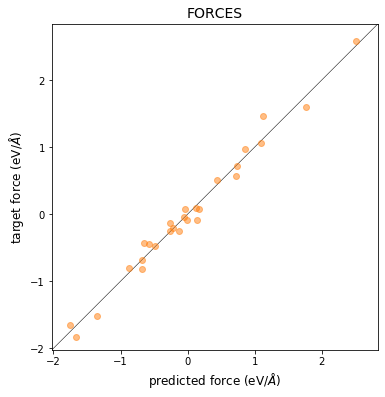

In [9]:
units = {
    'force': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pred = results.reshape(-1)
targ = targets.reshape(-1)

ax.scatter(pred, targ, color='#ff7f0e', alpha=0.5)

lim_min = min(np.min(pred), np.min(targ)) * 1.1
lim_max = max(np.max(pred), np.max(targ)) * 1.1

ax.set_xlim(lim_min, lim_max)
ax.set_ylim(lim_min, lim_max)
ax.set_aspect('equal')

ax.plot((lim_min, lim_max),
        (lim_min, lim_max),
        color='#000000',
        zorder=-1,
        linewidth=0.5)

ax.set_title('FORCES', fontsize=14)
ax.set_xlabel('predicted force (eV/$\\AA$)', fontsize=12)
ax.set_ylabel('target force (eV/$\\AA$)', fontsize=12)

plt.show()